# Libraries

In [1]:
import matplotlib.pyplot as plt
from scipy.linalg import bandwidth
from scipy.sparse import lil_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee as rcm
from math import inf, floor

# Implementations

## Sloan

In [2]:
def get_level_structure(node, adjacency_matrix):
    # Variáveis Iniciais
    level_structure = list()
    max_level_length = 0
    current_level_nodes = {node}
    last_level_nodes = set()
    next_level_nodes = set()

    # Calculando Nível Inicial
    node_degree = adjacency_matrix[node].count_nonzero()
    current_level = {node: node_degree}

    # Loop para cada Nível
    while True:
        # Adicionando Nível Atual à Lista de Níveis
        level_structure.append(current_level)
        next_level = dict()

        # Verificando Adjacência do Nível Atual
        for n in current_level:
            adjacent_nodes = adjacency_matrix[n].nonzero()[1]
            for a in adjacent_nodes:
                if (
                    (a not in last_level_nodes) and
                    (a not in current_level_nodes) and
                    (a not in next_level_nodes)
                ):
                    next_level_nodes.add(a)
                    next_level[a] = adjacency_matrix[a].count_nonzero()
        
        # Verificando se o Nível Atual é Vazio
        if len(next_level) == 0:
            break

        # Verificando se o Comprimento do Nível é o Maior
        if len(next_level) > max_level_length:
            max_level_length = len(next_level)
        
        # Intercambiando Níveis
        current_level = next_level
        last_level_nodes = current_level_nodes
        current_level_nodes = next_level_nodes
        next_level_nodes = set()
    
    return level_structure, max_level_length

def get_pseudo_peripheral_node_pair(adjacency_matrix):
    # Encontrando Node de Menor Grau como Chute Inicial
    n_nodes = adjacency_matrix.shape[0]
    pseudo_peripheral_node_1 = -1
    pseudo_peripheral_node_2 = -1
    min_degree = inf
    for node in range(1, n_nodes):
        degree = adjacency_matrix[node].count_nonzero()
        if degree < min_degree:
            min_degree = degree
            pseudo_peripheral_node_1 = node

    # Construindo Estrutura de Nível do Node Chutado
    level_structure, _ = get_level_structure(pseudo_peripheral_node_1, adjacency_matrix)
    
    # Processo de Seleção (Só termina quando Tivermos um Node Inicial e Outro Final)
    while pseudo_peripheral_node_2 == -1:
        # Inicializando um Comprimento Mínimo para o Nível de Maior Comprimento
        min_level_length = inf

        # Ordenando Último Nível pelo Grau
        ordered_level = level_structure[-1]
        ordered_level = sorted(ordered_level.keys(), key = lambda k: ordered_level[k])

        # Avaliando Canditados
        level_structure_length = len(level_structure)
        n_candidates = floor(len(ordered_level) / 2) + 1
        for candidate_node in ordered_level[:n_candidates]:
            # Construindo Estrutura de Nível do Node Candidato
            candidate_level_structure, candidate_max_level_length = get_level_structure(candidate_node, adjacency_matrix)

            # Verificando se Canditado pode Substituir o Node Escolhido Atual
            if candidate_max_level_length < min_level_length:
                # Avaliando se o Node pode ser Inicial ou Final
                if len(candidate_level_structure) > level_structure_length:
                    level_structure = candidate_level_structure
                    pseudo_peripheral_node_1 = candidate_node
                    break
                else:
                    pseudo_peripheral_node_2 = candidate_node
                    min_level_length = candidate_max_level_length

    return pseudo_peripheral_node_1, pseudo_peripheral_node_2

def reorder_sloan(adjacency_matrix):
    # Encontrando Nodes Pseudo-Periféricos Inicial e Final
    node_start, node_end = get_pseudo_peripheral_node_pair(adjacency_matrix)
    n_nodes = adjacency_matrix.shape[0]
    new_order = [0] * n_nodes

    # Calculando Lista de Distância para Node Final
    level_structure_end, _ = get_level_structure(node_end, adjacency_matrix)
    distances_to_end = [0] * n_nodes
    degrees = [0] * n_nodes
    for level_order, level in enumerate(level_structure_end):
        for node in level.keys():
            distances_to_end[node] = level_order
            degrees[node] = level[node]
    del level_structure_end

    # Atribuindo Status aos Nodes
    # 0 - posactive
    # 1 - active
    # 2 - preactive
    # 3 - inactive
    status = [3] * n_nodes

    # Atribuindo Prioridades
    W1 = 2
    W2 = 1
    priorities = list()
    for i in range(n_nodes):
        current_degree = degrees[i] + 1
        p = (n_nodes - current_degree) * W1 + distances_to_end[i] * W2
        priorities.append(p)
    
    # Iniciando Pilha de Nodes Elegíveis
    eligible_nodes = [node_start]
    status[node_start] = 2
    
    # Processo de Reordenação
    order = 0
    while len(eligible_nodes) != 0:
        # Ordenando Nodes por Prioridade
        eligible_nodes = sorted(eligible_nodes, key = lambda k: priorities[k])

        # Selecionando Node de Maior Prioridade
        highest_priority_node = eligible_nodes.pop()

        # Verificando se Node de Maior Prioridade é Pré-ativo
        if status[highest_priority_node] == 2:
            # Examinando Nodes Adjacentes
            adjacent_nodes_level_1 = adjacency_matrix[highest_priority_node].nonzero()[1]
            for a1 in adjacent_nodes_level_1:
                # Alterando Prioridade
                priorities[a1] += W1

                # Adicionando Node à Lista de Nodes Elegíveis e Atualizando Status se é Inativo
                if status[a1] == 3:
                    status[a1] = 2
                    eligible_nodes.append(a1)

        # Adicionando Nova Ordem ao Node de Maior Prioridade
        status[highest_priority_node] = 0
        new_order[highest_priority_node] = order
        order += 1

        # Examinando Nodes Adjacentes
        adjacent_nodes_level_1 = adjacency_matrix[highest_priority_node].nonzero()[1]
        for a1 in adjacent_nodes_level_1:
            # Verificando se Node de Maior Prioridade é Pré-ativo
            if status[a1] == 2:
                # Alterando Prioridade e Status
                priorities[a1] += W1
                status[a1] = 1

                # Examinando Nodes Adjacentes
                adjacent_nodes_level_2 = adjacency_matrix[a1].nonzero()[1]
                for a2 in adjacent_nodes_level_2:
                    # Verificando se Node de Maior Prioridade é Ativo ou Pré-ativo
                    if (status[a2] == 1) or (status[a2] == 2):
                        # Alterando Prioridade
                        priorities[a2] += W1

                    # Verificando se Node de Maior Prioridade é Inativo
                    elif status[a2] == 3:
                        # Alterando Prioridade, Status e Adicionando à Lista de Nodes Elegíveis
                        priorities[a2] += W1
                        status[a2] = 2
                        eligible_nodes.append(a2)

    return new_order

## Function Plot Results

In [3]:
# Exibindo Matrizes Esparsas
def plot_results(matrix_dict, markersize: 0.1):
    fig, ax = plt.subplots(1, len(matrix_dict))
    params = {
    'left': False, 
    'top': False, 
    'bottom': False,
    'labelleft': False, 
    'labeltop': False, 
    }

    for i, (algo, matrix) in enumerate(matrix_dict.items()):
        bd = bandwidth(matrix.toarray())
        title = f'({algo})\nMBW = {bd[0]}'
        ax[i].set_title(title)
        ax[i].spy(matrix, markersize=markersize)
        ax[i].tick_params(**params)

    plt.show()

# Matrix Tests

## Matrix 1 - Simple Graph

In [4]:
matrix_1 = lil_matrix((10, 10))

connections = ((0, 2), (2, 6), (6, 5), (5, 7), (7, 0), (7, 8), (7, 9), (8, 3), (3, 9), (8, 4), (4, 1))

for i, j in connections:
    matrix_1[i, j] = 1
    matrix_1[j, i] = 1

matrix_1 = matrix_1.tocsr()

In [5]:
# Reordenando Matriz - RCM
o1_rcm = rcm(matrix_1).tolist()
new_m1_rcm = lil_matrix(matrix_1.shape)
for i, j in zip(*matrix_1.nonzero()):
   i = o1_rcm.index(i)
   j = o1_rcm.index(j)
   new_m1_rcm[i, j] = True
new_m1_rcm = new_m1_rcm.tocsr()

# Reordenando Matriz - Sloan
o1_sloan = reorder_sloan(matrix_1)
new_m1_sloan = lil_matrix(matrix_1.shape)
for i, j in zip(*matrix_1.nonzero()):
   i = o1_sloan[i]
   j = o1_sloan[j]
   new_m1_sloan[i, j] = True
new_m1_sloan = new_m1_sloan.tocsr()

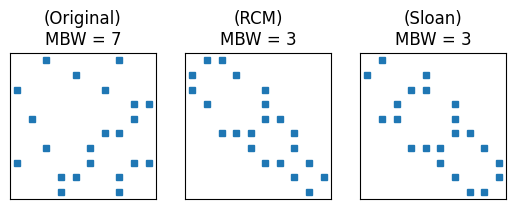

In [6]:
# Exibindo Matrizes Esparsas
matrix_dict = {
   'Original': matrix_1,
   'RCM': new_m1_rcm,
   'Sloan': new_m1_sloan
}

plot_results(matrix_dict, 4.0)

## Matrix 2 - lshp1270

In [7]:
# Lendo Dados
matrix_file = open('./matrix/lshp1270.mtx', 'r')
lines = matrix_file.readlines()
matrix_file.close()
i_s, j_s = [], []
for line in lines[13:]:
   i, j, *_ = line.split()
   i, j = int(i) - 1, int(j) - 1
   i_s.append(i)
   j_s.append(j)

# Construindo Matriz Esparsa
n = len(set(i_s))
matrix_2 = lil_matrix((n, n))
for i, j in zip(i_s, j_s):
   matrix_2[i, j] = 1
   matrix_2[j, i] = 1

matrix_2 = matrix_2.tocsr()

# Liberando Memória
del lines
del i_s
del j_s
del matrix_file

In [8]:
# Reordenando Matriz - RCM
o2_rcm = rcm(matrix_2).tolist()
new_m2_rcm = lil_matrix(matrix_2.shape)
for i, j in zip(*matrix_2.nonzero()):
   i = o2_rcm.index(i)
   j = o2_rcm.index(j)
   new_m2_rcm[i, j] = True
new_m2_rcm = new_m2_rcm.tocsr()

# Reordenando Matriz - Sloan
o2_sloan = reorder_sloan(matrix_2)
new_m2_sloan = lil_matrix(matrix_2.shape)
for i, j in zip(*matrix_2.nonzero()):
   i = o2_sloan[i]
   j = o2_sloan[j]
   new_m2_sloan[i, j] = True
new_m2_sloan = new_m2_sloan.tocsr()

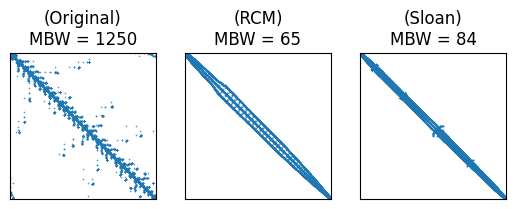

In [9]:
# Exibindo Matrizes Esparsas
matrix_dict = {
   'Original': matrix_2,
   'RCM': new_m2_rcm,
   'Sloan': new_m2_sloan
}

plot_results(matrix_dict, 0.2)